In [1]:
from utils import *
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

In [2]:
test_qids = np.array([9333, 9855, 9673, 9860])

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bias=True,
            dropout=0.0,
        )

        self.fc_1 = nn.Sequential(
            nn.Linear(11, 1),
        )

        self.fc_2 = nn.Sequential(
            nn.Linear(hidden_size // 1, hidden_size // 2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.LeakyReLU(),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.LeakyReLU(),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 8, output_size),
        )

        self.fc_b = nn.Linear(input_size - 69, input_size)

    def forward(self, x, x_2023):
        out = self.fc_1(x)
        out = out[..., 0]

        x_2023 = self.fc_b(x_2023)[:, None, ...]
        out = torch.cat([out, x_2023], dim=1)

        out, _ = self.lstm(out)
        out = out[:, -1, ...]

        out = self.fc_2(out)
        
        return out
    
model = LSTMModel(78, 512, 5, 1).to(DEVICE)
model.load_state_dict(torch.load("./models/lstm_trained_on_decade_price_data_22_08.pt"))

<All keys matched successfully>

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_X, path_x, path_y, p=0.0, smooth_labels=False):
        
        self.data_X = torch.load(path_X)
        self.data_X = self.data_X.permute(0, 1, 3, 2)
        self.data_x = torch.load(path_x)
        self.data_y = torch.load(path_y)

        self.p = p

    def __getitem__(self, index):
        if torch.rand(1) < self.p:
            return self.__transform(
                self.data_X[index].clone(),
                self.data_x[index].clone(),
                self.data_y[index].clone(),
            )
        else:
            return (
                self.data_X[index],
                self.data_x[index],
                self.data_y[index]
            )

    def __len__(self):
        return len(self.data_X)

    def __transform(self, item_X, item_x, item_y, k=2):
        max_price = max(item_X[:, -6, 0])
        item_x[-5] = k * max_price
        item_y = item_y * 0

        return item_X, item_x, item_y

In [5]:
test_dataset = CustomDataset(
    "./data/X_test_lstm_decade_price_12_09.pt",
    "./data/x_test_lstm_decade_price_12_09.pt",
    "./data/y_test_lstm_decade_price_12_09.pt",
)

X_test = test_dataset.data_X.double()
x_test = test_dataset.data_x.double()
y_test = test_dataset.data_y.double()

In [6]:
CONST_COLUMNS = [
    "Stellensubart_1",
    "Stellensubart_2",
    "Stellensubart_3",
    "Stellensubart_4",
    *[f"T{i}" for i in range(1, 35)],
    *[f"TD{i:02d}" for i in range(1, 35)],
    "Preis",
    "Beleuchtet",
    "Laenge",
    "Breite",
    "Eigenfläche",
    "PPSVACWert"
]

In [7]:
sample_to_explain = (X_test.to(DEVICE), x_test.to(DEVICE))  # Convert to Double
# Create an IntegratedGradients explainer
explainer = IntegratedGradients(model.double())  # Convert the model to Double as well

# Explain the model's prediction
attributions, delta = explainer.attribute(sample_to_explain, 
                                          target=0, 
                                          return_convergence_delta=True,
                                           n_steps=1_000)

# Plot the explanation
attributions = attributions[0].squeeze().cpu().detach().numpy()

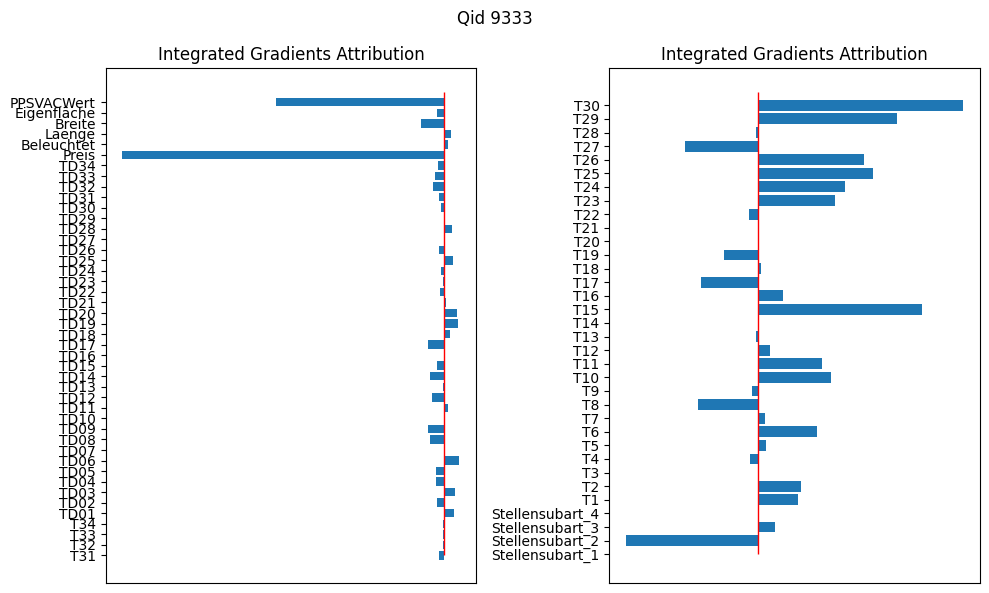

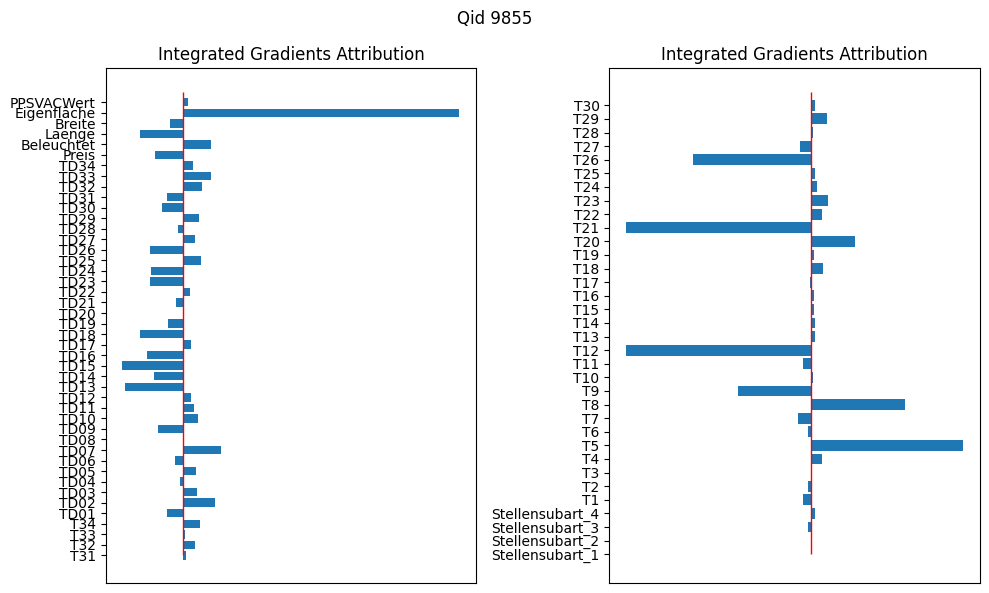

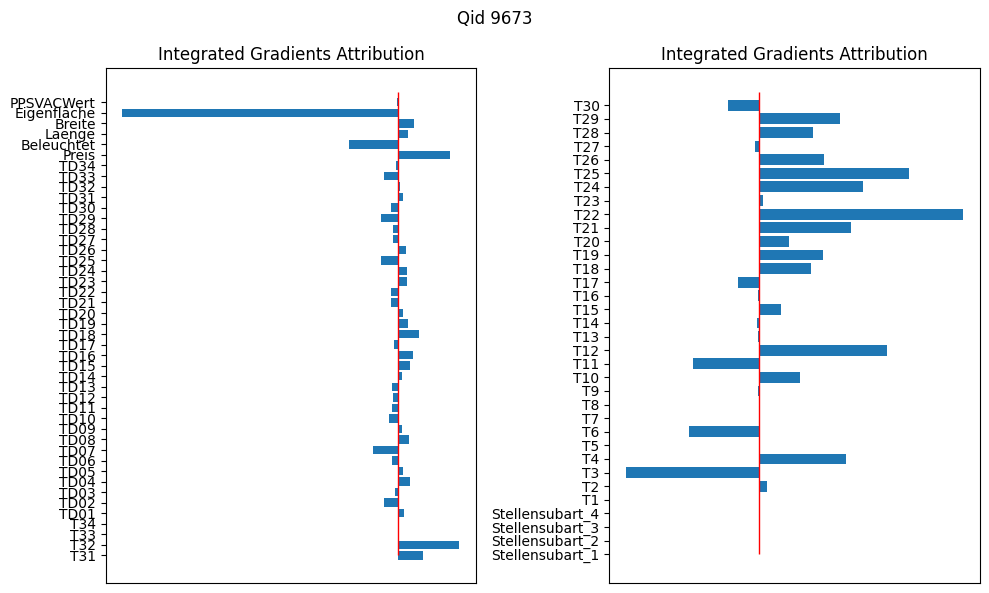

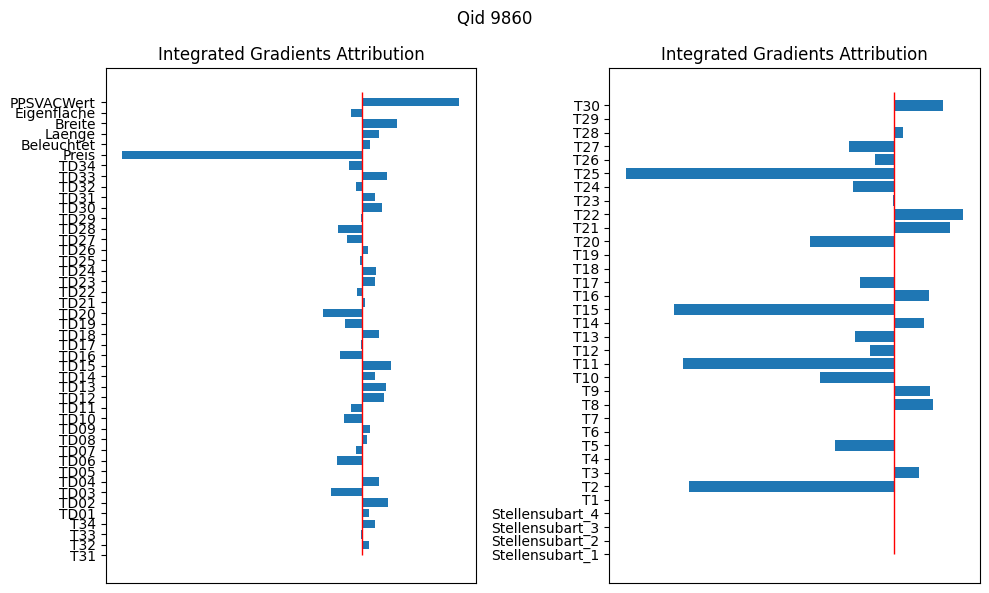

In [8]:
for i in range(4):
    
    fig, ax = plt.subplots(1,2, figsize=(10, 6))

    ax[0].barh(range(44), attributions[i].mean(axis=0).mean(axis=1)[34:])
    ax[0].set_title('Integrated Gradients Attribution')
    ax[0].set_xticks([])
    ax[0].set_yticks(range(44))
    ax[0].set_yticklabels(CONST_COLUMNS[34:], rotation=0, fontsize=10)
    ax[0].vlines(0, 0, 44, linestyles ="solid", colors ="r",linewidth=1)


    ax[1].barh(range(34), attributions[i].mean(axis=0).mean(axis=1)[:34])
    ax[1].set_title('Integrated Gradients Attribution')
    ax[1].set_xticks([])
    ax[1].set_yticks(range(34))
    ax[1].set_yticklabels(CONST_COLUMNS[:34], rotation=0, fontsize=10)
    ax[1].vlines(0, 0, 34, linestyles ="solid", colors ="r",linewidth=1)
    
    fig.suptitle(f"Qid {test_qids[i]}")

    plt.tight_layout()

    plt.show()